Downloaded rows: 3773
Columns: MultiIndex([('Adj Close', 'AAPL'),
            (    'Close', 'AAPL'),
            (     'High', 'AAPL'),
            (      'Low', 'AAPL'),
            (     'Open', 'AAPL'),
            (   'Volume', 'AAPL')],
           names=['Price', 'Ticker'])


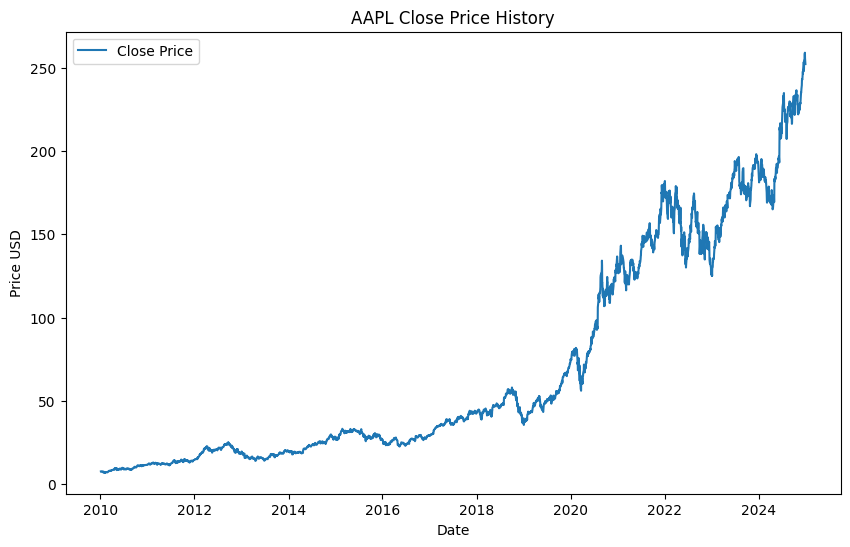

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 0.0080 - val_loss: 7.4429e-04
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 5.9208e-04 - val_loss: 0.0011
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 4.1607e-04 - val_loss: 9.6103e-04
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 4.9975e-04 - val_loss: 0.0028
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 3.7755e-04 - val_loss: 7.4109e-04
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 3.5986e-04 - val_loss: 0.0010
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 3.2507e-04 - val_loss: 7.3566e-04
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 3.1476e-04 - val_loss: 6.8171e-04
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 3.4023e-04 - val_loss: 8.9803e-04
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 3.4180e-04 - val_loss: 5.7910e-04
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


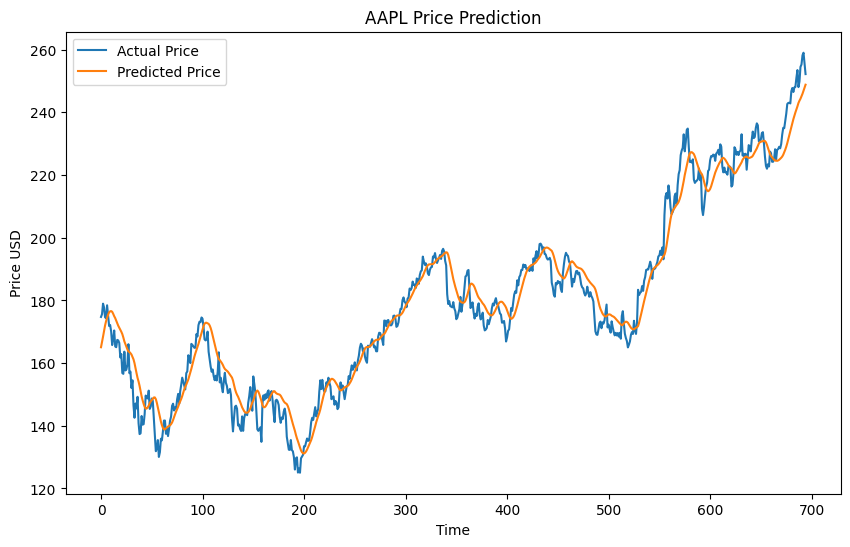

In [ ]:
# stock price prediction (LSTM)
# Install yfinance
!pip install yfinance

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Parameters
TICKER = "AAPL"
START_DATE = "2010-01-01"
END_DATE = "2024-12-31"

# Download Data with auto_adjust=False to keep 'Adj Close'
df = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False, auto_adjust=False)

print("Downloaded rows:", len(df))
print("Columns:", df.columns)

# Keep only existing columns
expected_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
df = df[[col for col in expected_cols if col in df.columns]]

# Plot Closing Price
plt.figure(figsize=(10, 6))
plt.plot(df['Close'], label='Close Price')
plt.title(f'{TICKER} Close Price History')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.legend()
plt.show()

# Prepare Data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']].values)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60
X_train, y_train = create_sequences(train_data, SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, SEQ_LENGTH)

# Reshape for LSTM [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Prediction of next closing price

model.compile(optimizer='adam', loss='mean_squared_error')

# Train Model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# Predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title(f'{TICKER} Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price USD')
plt.legend()
plt.show()
